In [1]:
import os
import pandas as pd
import pyfaidx
import pysam
from numpy import var, mean, sqrt
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# input files/dir
MUT_DATA = "../data/annotated_snv_mv_indels_by_cancer_subtype"
DRIVER_GENES = "../data/driver_genes"
TFBS_DATA = "../data/TFBS_data_diff"
REF_FASTA = "../data/ref/hg19.fa"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"

# output files/dir
TFBS_CHANGES = "../results/tfbs_changes"

if not os.path.exists(TFBS_CHANGES):
	os.makedirs(TFBS_CHANGES)

# Fasta sequence extractor
pyfaidx.Faidx(REF_FASTA)
REF_GENOME_OPEN = pysam.Fastafile(REF_FASTA) 

CANCER_TYPES = os.listdir(TFBS_DATA)
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
CANCER_TYPES.sort()
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['Biliary-AdenoCA', 'Bladder-TCC', 'Bone-Leiomyo', 'Bone-Osteosarc', 'Breast-AdenoCa', 'Breast-LobularCa', 'CNS-GBM', 'CNS-Medullo', 'CNS-Oligo', 'CNS-PiloAstro', 'Cervix-SCC', 'ColoRect-AdenoCA', 'Eso-AdenoCa', 'Head-SCC', 'Kidney-ChRCC', 'Kidney-RCC', 'Liver-HCC', 'Lung-AdenoCA', 'Lung-SCC', 'Lymph-BNHL', 'Lymph-CLL', 'Myeloid-AML', 'Myeloid-MPN', 'Ovary-AdenoCA', 'Panc-AdenoCA', 'Panc-Endocrine', 'Prost-AdenoCA', 'Skin-Melanoma', 'Stomach-AdenoCA', 'Thy-AdenoCA', 'Uterus-AdenoCA']


In [4]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [5]:
def cohen_d(x, y):
    # size of samples
    n1, n2 = len(x), len(y)
    # variance of the samples
    s1, s2 = var(x, ddof=1), var(y, ddof=1)
    # pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # means of the samples
    u1, u2 = mean(x), mean(y)
    # return the effect size
    return (u1 - u2) / s

def get_key(mutation):
	'''
	Generate a key to match the mutation format for TFBS data
	Used to merge the two dataframes on the mutation
	'''
	chrom, pos, ref, alt = mutation.split(":")
	pos = pos.split("-")[0]
	# using 0-based indexing for pysam fetch
	start = int(pos)-1
	end = int(pos)
	# include the previous base in case of indels and MNVs
	if ref == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		pos = int(pos) - 1
	elif alt == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		pos = int(pos) - 1
	elif len(ref) > 1 or len(alt) > 1:
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start) + alt
		pos = int(pos) - 1
	key = f"chr{chrom}:{pos}{ref}>{alt}"
	return key

def get_prediction(group1, group2):
    if group1.median() <= 0 and group2.median() <= 0:
        return "loss"
    elif group1.median() >= 0 and group2.median() >= 0:
        return "gain"
    elif group1.median() <= 0 and group2.median() >= 0:
        return "loss to gain"
    elif group1.median() >= 0 and group2.median() <= 0:
        return "gain to loss"
    else:
        return "no change"

In [6]:
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	mut_cancer_df = pd.read_csv(f"{MUT_DATA}/{cancer_type}.tsv", sep="\t")
	# mutations in driver genes
	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	mut_cancer_df = mut_cancer_df[mut_cancer_df["gene"].isin(driver_genes_list)]
	mut_cancer_df = mut_cancer_df[["Tumor_Sample_Barcode", "mutation", "gene", "driver", "has_driver", "genic_region"]]
	mut_cancer_df["cancer_type"] = cancer_type
	mut_df = pd.concat([mut_df, mut_cancer_df])
# get driver status
mut_df["driver_status"] = mut_df.apply(lambda x: "Passengers in presence of driver" if x["has_driver"] else "Passengers in absence of driver", axis=1)
mut_df["driver_status"] = mut_df.apply(lambda x: "Drivers" if x["driver"] else x["driver_status"], axis=1)
print(mut_df.shape)
# add variant column to use as key for TFBS data
mut_df["variant"] = mut_df["mutation"].apply(get_key)
print(mut_df.shape)
mut_df.head()

(90258, 8)
(90258, 9)


,Tumor_Sample_Barcode,mutation,gene,driver,has_driver,genic_region,cancer_type,driver_status,variant
4893,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,16:64995960-64995960:T:A,CDH11,False,False,intronic,Biliary-AdenoCA,Passengers in absence of driver,chr16:64995960T>A
4894,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,16:65021115-65021115:G:T,CDH11,False,False,intronic,Biliary-AdenoCA,Passengers in absence of driver,chr16:65021115G>T
4895,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,16:65078980-65078980:C:A,CDH11,False,False,intronic,Biliary-AdenoCA,Passengers in absence of driver,chr16:65078980C>A
4896,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,16:65122834-65122834:C:A,CDH11,False,False,intronic,Biliary-AdenoCA,Passengers in absence of driver,chr16:65122834C>A
4998,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,17:7577560-7577560:A:G,TP53,True,True,exonic,Biliary-AdenoCA,Drivers,chr17:7577560A>G


In [7]:
print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

(90258, 9)
(82512, 9)


In [8]:
# TFBS data
tfbs_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	# read the TFBS data
	tfbs_cancer_df = pd.read_csv(f"{TFBS_DATA}/{cancer_type}.tsv", sep="\t")
	tfbs_cancer_df["cancer_type"] = cancer_type
	tfbs_df = pd.concat([tfbs_df, tfbs_cancer_df])
tfbs_df["abs_score"] = tfbs_df["score"].abs()
print(tfbs_df.shape)
tfbs_df.head()

(86288302, 5)


,variant,tf,score,cancer_type,abs_score
0,chr10:123235487CAT>C,ABCF2,-0.055900,Biliary-AdenoCA,0.055900
1,chr10:123235487CAT>C,ADARB1,-0.058200,Biliary-AdenoCA,0.058200
2,chr10:123235487CAT>C,AFF4,0.023300,Biliary-AdenoCA,0.023300
3,chr10:123235487CAT>C,AHR,0.244525,Biliary-AdenoCA,0.244525
4,chr10:123235487CAT>C,AIRE,-0.267100,Biliary-AdenoCA,0.267100


In [9]:
tfbs_selected = tfbs_df.copy()
tfbs_selected = tfbs_selected[tfbs_selected["abs_score"] > 0.5]
tfbs_selected = pd.merge(tfbs_selected, mut_df[["variant", "gene", "genic_region", "driver", "driver_status"]], on="variant", how="inner")
print(tfbs_selected.shape)
tfbs_selected.drop_duplicates(inplace=True)
print(tfbs_selected.shape)
tfbs_selected = tfbs_selected[~tfbs_selected["driver"]]
print(tfbs_selected.shape)
tfbs_selected.head()

(761941, 9)
(686784, 9)
(671434, 9)


,variant,tf,score,cancer_type,abs_score,gene,genic_region,driver,driver_status
0,chr10:123245541C>T,AFF4,-0.7516,Biliary-AdenoCA,0.7516,FGFR2,intronic,False,Passengers in absence of driver
1,chr10:123245541C>T,AKR1A1,-0.8086,Biliary-AdenoCA,0.8086,FGFR2,intronic,False,Passengers in absence of driver
2,chr10:123245541C>T,C9ORF156,-0.6514,Biliary-AdenoCA,0.6514,FGFR2,intronic,False,Passengers in absence of driver
3,chr10:123245541C>T,GPD1,-0.5611,Biliary-AdenoCA,0.5611,FGFR2,intronic,False,Passengers in absence of driver
4,chr10:123245541C>T,MTHFD1,-0.8425,Biliary-AdenoCA,0.8425,FGFR2,intronic,False,Passengers in absence of driver


In [10]:
# get the biggest effects for each mutation
tfbs_max = tfbs_df.groupby("variant").agg({
    'abs_score': 'max'
}).reset_index()
mut_data_df = mut_df[["Tumor_Sample_Barcode", "cancer_type", "gene", "variant", "driver_status", "genic_region"]].copy()
print(mut_data_df.shape)
mut_data_df["genic_region"] = mut_data_df["genic_region"].replace({
    "ncRNA_exonic": "ncRNA",
    "ncRNA_intronic": "ncRNA"
})
mut_data_df = mut_data_df.merge(tfbs_max, on="variant", how="left")
mut_data_df.rename(columns={"abs_score": "tfbs_effect"}, inplace=True)
mut_data_df["tfbs_effect"] = mut_data_df["tfbs_effect"].fillna(0)
print(mut_data_df.shape)
mut_data_df.head()

(82512, 6)
(82512, 7)


,Tumor_Sample_Barcode,cancer_type,gene,variant,driver_status,genic_region,tfbs_effect
0,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,Biliary-AdenoCA,CDH11,chr16:64995960T>A,Passengers in absence of driver,intronic,0.7090
1,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,Biliary-AdenoCA,CDH11,chr16:65021115G>T,Passengers in absence of driver,intronic,0.8161
2,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,Biliary-AdenoCA,CDH11,chr16:65078980C>A,Passengers in absence of driver,intronic,0.8741
3,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,Biliary-AdenoCA,CDH11,chr16:65122834C>A,Passengers in absence of driver,intronic,0.8733
4,1e2dcbcc-771c-43c5-8c8d-e0eb77cb3494,Biliary-AdenoCA,TP53,chr17:7577560A>G,Drivers,exonic,0.8911


['UTR5', 'UTR3', 'ncRNA', 'exonic', 'intronic', 'upstream', 'downstream']
[(('UTR5', 'Passengers in presence of driver'), ('UTR5', 'Passengers in absence of driver')), (('UTR3', 'Passengers in presence of driver'), ('UTR3', 'Passengers in absence of driver'))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



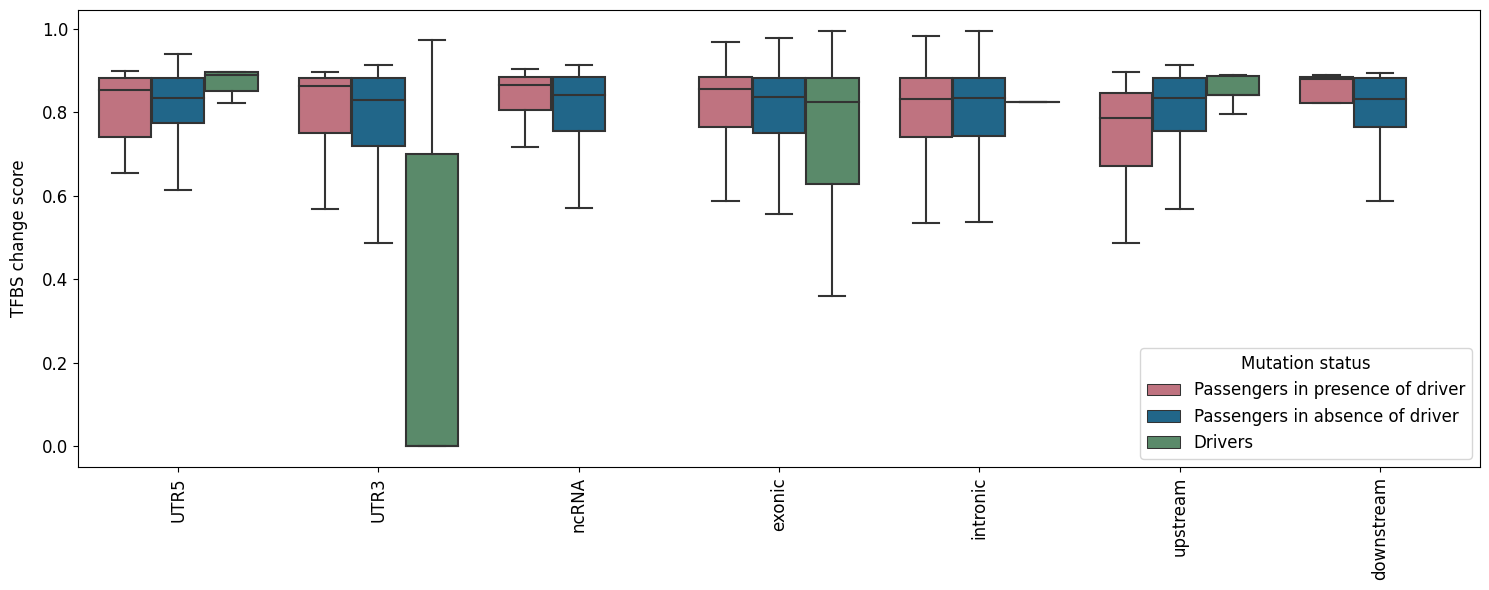

In [11]:
plt.figure(figsize=(15, 6))
hue_order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

genic_regions = ["UTR5", "UTR3", "ncRNA", "exonic", "intronic", "upstream", "downstream"]
print(genic_regions)

sns.boxplot(
	x="genic_region",
	y="tfbs_effect",
    hue="driver_status",
	data=mut_data_df,
	palette=cmap,
	order=genic_regions,
	hue_order=hue_order,
	showfliers=False,
)
plt.xlabel("")
plt.xticks(fontsize=12, rotation=90)
plt.ylabel("TFBS change score", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.legend(title="Mutation status", fontsize=12, title_fontsize='12')
# plt.legend([])

# get statistical significance annotations
box_pairs = []
for region in genic_regions:
	region_data = mut_data_df[mut_data_df["genic_region"] == region]
	if "Passengers in presence of driver" in region_data["driver_status"].unique().tolist() \
			and "Passengers in absence of driver" in region_data["driver_status"].unique().tolist():
		box_pairs.append(((region, "Passengers in presence of driver"), (region, "Passengers in absence of driver")))
	else:
		continue
print(box_pairs[:2])

annotator = Annotator(
    plt.gca(),
	x="genic_region",
	y="tfbs_effect",
    hue="driver_status",
	data=mut_data_df,
    order=genic_regions,
	hue_order=hue_order,
    pairs=box_pairs
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.tight_layout()

In [12]:
# get mutations in promoter (upstream) regions
mut_data_df = mut_data_df[mut_data_df["genic_region"] == "upstream"]
# mut_data_df = mut_data_df[mut_data_df["tfbs_effect"] >= 0.2]
print(mut_data_df.shape)
mut_data_df.head()

(412, 7)


,Tumor_Sample_Barcode,cancer_type,gene,variant,driver_status,genic_region,tfbs_effect
324,0c7aca3f-e006-4de3-afc2-20b4f727d4fd,Bladder-TCC,TERT,chr5:1295250G>A,Drivers,upstream,0.8873
350,2b142863-b963-4cc9-8f8f-c72503c93390,Bladder-TCC,TERT,chr5:1295250G>A,Drivers,upstream,0.8873
360,301d6ce3-4099-4c1d-8e50-c04b7ce91450,Bladder-TCC,KMT2D,chr12:49449996G>C,Passengers in absence of driver,upstream,0.8372
383,301d6ce3-4099-4c1d-8e50-c04b7ce91450,Bladder-TCC,FGFR3,chr4:1794415C>T,Passengers in presence of driver,upstream,0.7246
388,301d6ce3-4099-4c1d-8e50-c04b7ce91450,Bladder-TCC,TERT,chr5:1295228G>A,Drivers,upstream,0.8398


In [13]:
mut_data_cancer_df = mut_data_df.groupby(["cancer_type", "driver_status"]).agg({
	"tfbs_effect": "mean",
}).reset_index()
mut_data_cancer_df.head()

,cancer_type,driver_status,tfbs_effect
0,Bladder-TCC,Drivers,0.85040
1,Bladder-TCC,Passengers in absence of driver,0.81215
2,Bladder-TCC,Passengers in presence of driver,0.72460
3,Bone-Leiomyo,Passengers in absence of driver,0.74375
4,Breast-AdenoCa,Passengers in absence of driver,0.75860


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Passengers in presence of driver vs. Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:4.399e-02 U_stat=1.587e+03
Passengers in absence of driver vs. Drivers: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:2.494e-03 U_stat=1.430e+04


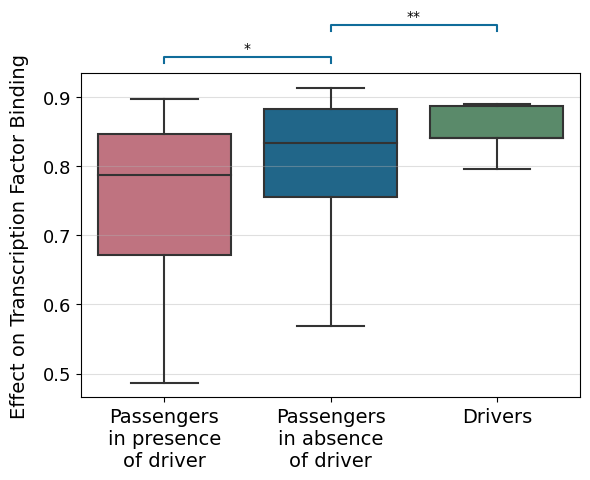

In [23]:
# add grid lines
fig, ax = plt.subplots(figsize=(6, 5))
order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax.grid(axis='y', alpha=0.4)
sns.boxplot(
    x="driver_status",
	y="tfbs_effect",
	data=mut_data_df,
	palette=cmap,
	order=order,
	showfliers=False,
)
plt.xlabel("")
plt.ylabel("Effect on Transcription Factor Binding", fontsize=14, labelpad=10)
plt.yticks(fontsize=13)
# change x labels
plt.xticks(ticks=[0, 1, 2], labels=["Passengers\nin presence\nof driver", "Passengers\nin absence\nof driver", "Drivers"], fontsize=14)


# get statistical significance annotations
box_pairs = [("Passengers in presence of driver", "Passengers in absence of driver"), \
              ("Passengers in absence of driver", "Drivers")]

annotator = Annotator(
    plt.gca(),
    x="driver_status",
	y="tfbs_effect",
	data=mut_data_df,
    order=order,
    pairs=box_pairs
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.tight_layout()
plt.savefig(f"{TFBS_CHANGES}/Pancancer.png", dpi=300)

In [16]:
mut_data_sample_df = mut_data_df.groupby(["Tumor_Sample_Barcode", "driver_status"]).agg({
	"tfbs_effect": "mean",
    "cancer_type": "first",
}).reset_index()
mut_data_sample_df.head()

,Tumor_Sample_Barcode,driver_status,tfbs_effect,cancer_type
0,0040b1b6-b07a-4b6e-90ef-133523eaf412,Drivers,0.839800,Liver-HCC
1,02917220-6a7a-46a1-8656-907e96bef88e,Passengers in absence of driver,0.824733,Lymph-BNHL
2,0332b017-17d5-4083-8fc4-9d6f8fdbbbde,Drivers,0.839800,CNS-GBM
3,03ad38a6-0902-4aaa-84a3-91ea88fa9883,Passengers in absence of driver,0.889200,Lymph-BNHL
4,03c88506-d72e-4a44-a34e-a7f0564f1799,Drivers,0.839800,Liver-HCC


['Bladder', 'Bone', 'Breast', 'CNS', 'ColoRect', 'Eso', 'Head', 'Kidney', 'Liver', 'Lung', 'Lymph', 'Ovary', 'Panc', 'Prost', 'Skin', 'Stomach', 'Thy', 'Uterus']
[(('Bladder', 'Passengers in presence of driver'), ('Bladder', 'Passengers in absence of driver')), (('CNS', 'Passengers in presence of driver'), ('CNS', 'Passengers in absence of driver'))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



/Users/akshatha/miniforge3/envs/cancer-model/lib/python3.9/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,
/Users/akshatha/miniforge3/envs/cancer-model/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/akshatha/miniforge3/envs/cancer-model/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


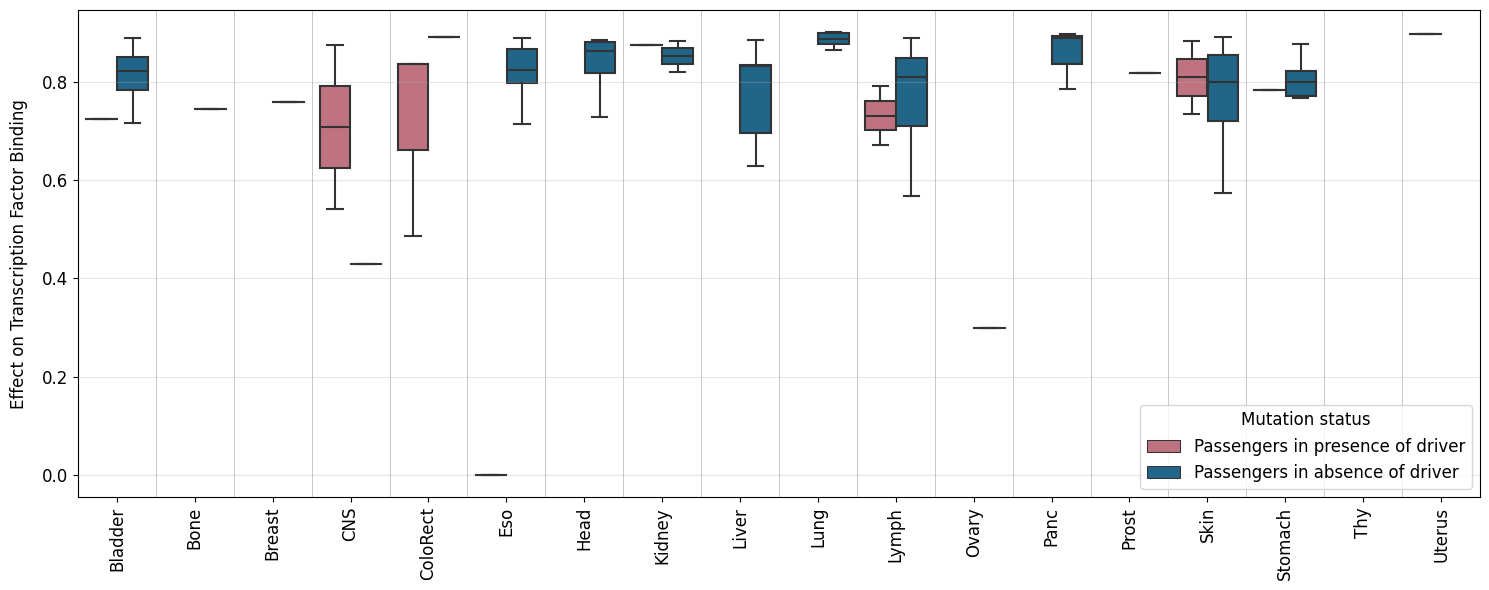

In [17]:
plt.figure(figsize=(15, 6))
hue_order = ["Passengers in presence of driver", "Passengers in absence of driver"]
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

mut_data_sample_df["organ"] = mut_data_sample_df["cancer_type"].apply(lambda x: x.split("-")[0])
cancers = mut_data_sample_df["organ"].unique().tolist()
cancers.sort()
print(cancers)


ax = sns.boxplot(
	x="organ",
	y="tfbs_effect",
    hue="driver_status",
	data=mut_data_sample_df,
	palette=cmap,
	order=cancers,
	hue_order=hue_order,
	showfliers=False,
)
plt.xlabel("")
plt.xticks(fontsize=12, rotation=90)
plt.ylabel("Effect on Transcription Factor Binding", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.legend(title="Mutation status", fontsize=12, title_fontsize='12')

# add grid lines
ax.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
	cancer_data = mut_data_sample_df[mut_data_sample_df["organ"] == cancer]
	if "Passengers in presence of driver" in cancer_data["driver_status"].unique().tolist() \
			and "Passengers in absence of driver" in cancer_data["driver_status"].unique().tolist():
		box_pairs.append(((cancer, "Passengers in presence of driver"), (cancer, "Passengers in absence of driver")))
	else:
		continue
print(box_pairs[:2])

annotator = Annotator(
    plt.gca(),
	x="organ",
	y="tfbs_effect",
    hue="driver_status",
	data=mut_data_sample_df,
    order=cancers,
	hue_order=hue_order,
    pairs=box_pairs
)
annotator.configure(test='t-test_ind', text_format='star', loc='outside', hide_non_significant=True, color='black')
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.tight_layout()
# plt.savefig(f"{TFBS_CHANGES}/all_cancers.png", dpi=300)

In [19]:
# get genes with atleast 5 mutations
genes = mut_data_df["gene"].unique().tolist()
gene_counts = mut_data_df["gene"].value_counts()
# print(gene_counts)
gene_counts = gene_counts[gene_counts >= 5]
genes = gene_counts.index.tolist()
genes.reverse()
print(genes)
cancer_gene_count = mut_data_df.groupby("gene").agg({
    "cancer_type": lambda x: x.unique(),
	"Tumor_Sample_Barcode": "nunique",
}).reset_index()
cancer_gene_count.head()


['ROBO2', 'APC', 'CSMD3', 'CYP2C8', 'TERT', 'BCL2']


,gene,cancer_type,Tumor_Sample_Barcode
0,APC,"[ColoRect-AdenoCA, Eso-AdenoCa, Liver-HCC]",6
1,ARID1A,"[Liver-HCC, Lymph-BNHL, Uterus-AdenoCA]",4
2,ARID2,"[Liver-HCC, Skin-Melanoma]",2
3,AXIN1,[Liver-HCC],1
4,BCL2,[Lymph-BNHL],38


[(('APC', 'Passengers in presence of driver'), ('APC', 'Passengers in absence of driver')), (('TERT', 'Passengers in presence of driver'), ('TERT', 'Passengers in absence of driver'))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



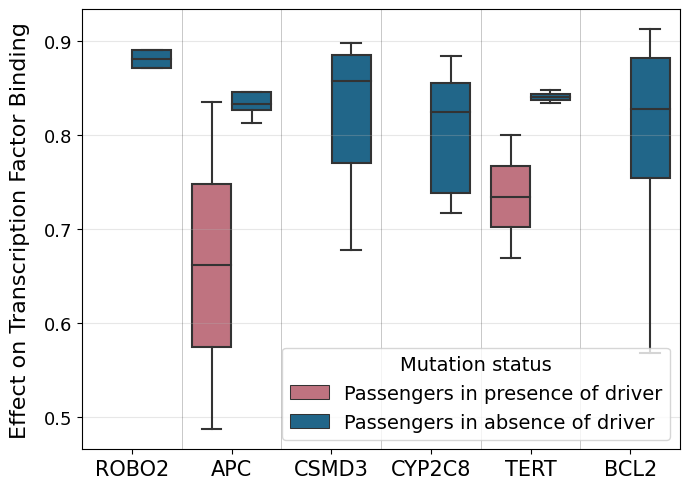

In [29]:
plt_len = max(len(genes), 8) - 1
plt.figure(figsize=(plt_len, 5))
hue_order = ["Passengers in presence of driver", "Passengers in absence of driver"]
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

ax = sns.boxplot(
	x="gene",
	y="tfbs_effect",
    hue="driver_status",
	data=mut_data_df,
	palette=cmap,
	order=genes,
	hue_order=hue_order,
	showfliers=False,
)
plt.xlabel("")
plt.xticks(fontsize=15)
plt.ylabel("Effect on Transcription Factor Binding", fontsize=16, labelpad=10)
plt.yticks(fontsize=13)
plt.legend(title="Mutation status", fontsize=14, title_fontsize=14, loc="lower right")

# add grid lines
ax.grid(axis='y', alpha=0.3)
for i in range(len(genes) - 1):
	ax.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# get statistical significance annotations
box_pairs = []
for gene in genes:
	gene_data = mut_data_df[mut_data_df["gene"] == gene]
	if "Passengers in presence of driver" in gene_data["driver_status"].unique().tolist() \
			and "Passengers in absence of driver" in gene_data["driver_status"].unique().tolist():
		box_pairs.append(((gene, "Passengers in presence of driver"), (gene, "Passengers in absence of driver")))
	else:
		continue
print(box_pairs[:2])

annotator = Annotator(
    plt.gca(),
	x="gene",
	y="tfbs_effect",
    hue="driver_status",
	data=mut_data_df,
    order=genes,
	hue_order=hue_order,
    pairs=box_pairs
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.tight_layout()